# Insights
* Which stations had the most traffic in 2018? What is their percentage share?
* Are popular stations gaining/losing traffic over time?
* Which lines had the most traffic in 2018? What is their percentage share?
* Are popular lines gaining/losing traffic over time?
* What is the mean, median, standard deviation for traffic for all Japanese railway stations in 2018?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
# style.use('seaborn-poster')
style.use('ggplot')
import numpy as np
import requests

## Querying the API

In [2]:
endpoint = 'https://api-tokyochallenge.odpt.org/api/v4/'
rdf_type = 'PassengerSurvey'

with open('./api_key.txt', 'r') as f:
    api_key = f.readline().strip()
    
url = f'{endpoint}odpt:{rdf_type}.json?&acl:consumerKey={api_key}'
res = requests.get(url)
df = pd.read_json(res.text)

In [3]:
df.head()

,@context,@id,@type,dc:date,odpt:includeAlighting,odpt:operator,odpt:passengerSurveyObject,odpt:railway,odpt:station,owl:sameAs
0,http://vocab.odpt.org/context_odpt.jsonld,urn:ucode:_00001C000000000000010000032095F0,odpt:PassengerSurvey,2019-08-09T10:00:00+09:00,False,odpt.Operator:TWR,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",[odpt.Railway:TWR.Rinkai],[odpt.Station:TWR.Rinkai.KokusaiTenjijo],odpt.PassengerSurvey:TWR.KokusaiTenjijo
1,http://vocab.odpt.org/context_odpt.jsonld,urn:ucode:_00001C000000000000010000032095F1,odpt:PassengerSurvey,2019-08-09T10:00:00+09:00,False,odpt.Operator:TWR,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",[odpt.Railway:TWR.Rinkai],[odpt.Station:TWR.Rinkai.Oimachi],odpt.PassengerSurvey:TWR.Oimachi
2,http://vocab.odpt.org/context_odpt.jsonld,urn:ucode:_00001C000000000000010000032095F2,odpt:PassengerSurvey,2019-08-09T10:00:00+09:00,False,odpt.Operator:TWR,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",[odpt.Railway:TWR.Rinkai],[odpt.Station:TWR.Rinkai.Osaki],odpt.PassengerSurvey:TWR.Osaki
3,http://vocab.odpt.org/context_odpt.jsonld,urn:ucode:_00001C000000000000010000032095F3,odpt:PassengerSurvey,2019-08-09T10:00:00+09:00,False,odpt.Operator:TWR,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",[odpt.Railway:TWR.Rinkai],[odpt.Station:TWR.Rinkai.ShinKiba],odpt.PassengerSurvey:TWR.ShinKiba
4,http://vocab.odpt.org/context_odpt.jsonld,urn:ucode:_00001C000000000000010000032095F4,odpt:PassengerSurvey,2019-08-09T10:00:00+09:00,False,odpt.Operator:TWR,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",[odpt.Railway:TWR.Rinkai],[odpt.Station:TWR.Rinkai.ShinagawaSeaside],odpt.PassengerSurvey:TWR.ShinagawaSeaside


## Preprocessing and utility functions

In [4]:
# Utility functions
from_year = lambda d, year: d['odpt:surveyYear'] == year
contains_year = lambda arr, year: any([from_year(d, year) for d in arr])
psgr_cnt_year = lambda arr, year: [d['odpt:passengerJourneys'] for d in arr if from_year(d, year)][0]
traffic_year = lambda year: [psgr_cnt_year(row['odpt:passengerSurveyObject'], year)
                             if contains_year(row['odpt:passengerSurveyObject'], year)
                             else None
                             for _, row in df.iterrows()]


## Preprocessing

# Halve passengerJourneys count for rows where includeAlighting == True
for idx, _ in df.iterrows():
    if df.at[idx, 'odpt:includeAlighting']:
        for d in df.at[idx, 'odpt:passengerSurveyObject']:
            d['odpt:passengerJourneys'] //= 2

# Drop unnecessary columns
df.drop(columns=['@context',
                 '@id',
                 '@type',
                 'dc:date',
                 'odpt:includeAlighting',
                 'odpt:operator',
                 'odpt:station'], inplace=True)

# Expand railways list into separate rows
df = df['odpt:railway'] \
         .apply(pd.Series) \
         .merge(df, right_index=True, left_index=True) \
         .drop(['odpt:railway'], axis=1) \
         .melt(id_vars=['odpt:passengerSurveyObject', 'owl:sameAs'], value_name='odpt:railway') \
         .drop("variable", axis=1) \
         .dropna()

# Format railway and station names
for idx, _ in df.iterrows():
    df.at[idx, 'odpt:railway'] = df.at[idx, 'odpt:railway'].split('.')[-1]
    df.at[idx, 'owl:sameAs'] = df.at[idx, 'owl:sameAs'].split('.')[-1]

# Add columns for traffic data from each year
years = [2013, 2014, 2015, 2016, 2017, 2018]
for year in years:
    df[f'traffic_{year}'] = traffic_year(year)
    df[f'traffic_prop_{year}'] = df[f'traffic_{year}'] / df.sum()[f'traffic_{year}']

In [5]:
df.head()

,odpt:passengerSurveyObject,owl:sameAs,odpt:railway,traffic_2013,traffic_prop_2013,traffic_2014,traffic_prop_2014,traffic_2015,traffic_prop_2015,traffic_2016,traffic_prop_2016,traffic_2017,traffic_prop_2017,traffic_2018,traffic_prop_2018
0,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",KokusaiTenjijo,Rinkai,NaN,NaN,NaN,NaN,35679.0,0.000629,34238.0,0.000522,34494.0,0.000482,33593.0,0.000490
1,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",Oimachi,Rinkai,NaN,NaN,NaN,NaN,40645.0,0.000716,41855.0,0.000638,42961.0,0.000601,44308.0,0.000646
2,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",Osaki,Rinkai,NaN,NaN,NaN,NaN,59203.0,0.001043,61340.0,0.000935,63766.0,0.000892,65415.0,0.000954
3,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",ShinKiba,Rinkai,NaN,NaN,NaN,NaN,31651.0,0.000558,32062.0,0.000488,33268.0,0.000465,34148.0,0.000498
4,"[{'odpt:surveyYear': 2015, 'odpt:passengerJour...",ShinagawaSeaside,Rinkai,NaN,NaN,NaN,NaN,19754.0,0.000348,22045.0,0.000336,23332.0,0.000326,23686.0,0.000345


## Which stations had the most traffic in 2018? What was their percentage share?

In [6]:
station_by_traffic = df.filter(['owl:sameAs', 'traffic_2018', 'traffic_prop_2018']) \
                       .groupby('owl:sameAs') \
                       .sum() \
                       .sort_values(by='traffic_2018', ascending=False)

# Top 10 busiest Tokyo train stations in 2018
station_by_traffic.head(10)

,traffic_2018,traffic_prop_2018
owl:sameAs,,
Shinjuku,5124685.0,0.074723
Tokyo,4780787.0,0.069708
Shibuya,3677302.0,0.053619
Ikebukuro,3050076.0,0.044473
Yokohama,2174339.0,0.031704
Shinagawa,1989209.0,0.029005
Shimbashi,1536694.0,0.022406
Omiya,1359421.0,0.019822
Ueno,1156670.0,0.016865


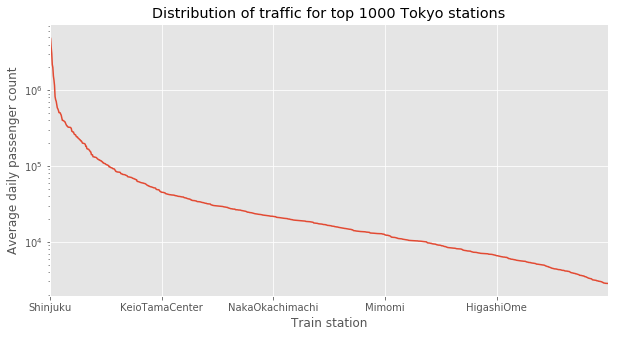

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
station_by_traffic.filter(['owl:sameAs', 'traffic_2018']).head(1000).plot(logy=True, legend=False, ax=ax)
plt.title('Distribution of traffic for top 1000 Tokyo stations')
plt.xlabel('Train station')
plt.ylabel('Average daily passenger count')
plt.show()

## Which railways had the most traffic in 2018? What was their percentage share?

In [8]:
railway_by_traffic = df.filter(['odpt:railway', 'traffic_2018', 'traffic_prop_2018']) \
                       .groupby('odpt:railway') \
                       .sum() \
                       .sort_values(by='traffic_2018', ascending=False)

# Top 10 busiest Tokyo train lines in 2018
railway_by_traffic.head(10)

,traffic_2018,traffic_prop_2018
odpt:railway,,
Yamanote,5468536.0,0.079737
KeihinTohokuNegishi,5036356.0,0.073435
ChuoSobuLocal,3531223.0,0.051489
ShonanShinjuku,3404359.0,0.049639
ChuoRapid,2932418.0,0.042757
SaikyoKawagoe,2787835.0,0.040649
Tokaido,2366691.0,0.034509
Yokosuka,2149195.0,0.031337
JobanRapid,1990355.0,0.029021


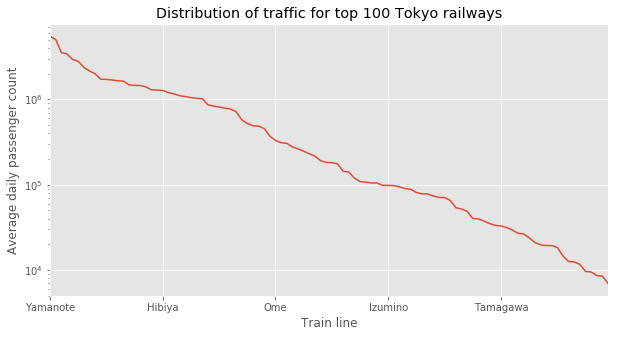

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
railway_by_traffic.filter(['odpt:railway', 'traffic_2018']).head(100).plot(logy=True, legend=False, ax=ax)
plt.title('Distribution of traffic for top 100 Tokyo railways')
plt.xlabel('Train line')
plt.ylabel('Average daily passenger count')
plt.show()

## What is the mean, median, standard deviation for traffic for all Japanese railway stations in 2018?

In [10]:
station_by_traffic.describe()

,traffic_2018,traffic_prop_2018
count,1.392000e+03,1392.000000
mean,4.926908e+04,0.000718
std,2.575981e+05,0.003756
min,0.000000e+00,0.000000
25%,2.103750e+03,0.000031
50%,9.043500e+03,0.000132
75%,2.542950e+04,0.000371
max,5.124685e+06,0.074723


In [11]:
railway_by_traffic.describe()

,traffic_2018,traffic_prop_2018
count,1.100000e+02,110.000000
mean,6.234778e+05,0.009091
std,1.000722e+06,0.014591
min,0.000000e+00,0.000000
25%,3.003025e+04,0.000438
50%,1.141545e+05,0.001664
75%,9.790812e+05,0.014276
max,5.468536e+06,0.079737


## Visualize the trend for ALL railway traffic in Japan from 2013 to 2018.

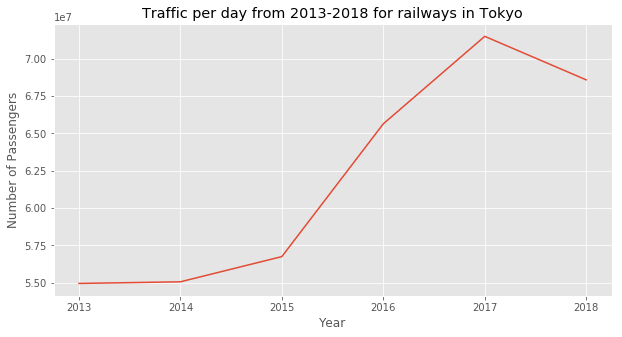

In [12]:
cumsum = df.filter(regex='traffic_201[345678]$', axis=1).sum()
plt.figure(figsize=(10, 5))
plt.title('Traffic per day from 2013-2018 for railways in Tokyo')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.plot([2013, 2014, 2015, 2016, 2017, 2018], cumsum)
plt.show()